# Predicting what bank customers purchase based on demographics
## Gradient-boosted decision trees and random forests

Summary: Below I compared gradient-boosted decision tree, random forest, and standard decision trees in predicting whether a bank customer will purchase a  PEP  (Personal  Equity Plan) after a bank's last mailing (YES/NO) using the customer's demographic information.

The best performance between a decision tree, a random forest, and a gradient boosted random forest was the decision tree. However, more tweaking of hte hyper paramaters was done for this classifer type.

F1 scores
Decision tree:0.87
random forest:0.79
gradient boosted random forest:0.83

Data Source:
    
Nalini, Yadav Akurdi,Pune, IndiaK. Rajeswari, Akurdi,Pune,V. Vaithiyanathan, Ph.D
Usage of Classification based Association for Removal of Noisy Attributes
https://pdfs.semanticscholar.org/7f87/80d5b6d2aa8cba670bf189bc994f3bbc43bf.pdf

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split 

from sklearn.tree import DecisionTreeClassifier 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_auc_score

import os

from IPython.display import Image

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
bank=pd.read_csv(r'https://raw.githubusercontent.com/Rylan-L/data_science/master/data_sets/Bank%20Data.csv')
#replae yes no with true false
bank =bank.replace({'YES': True, 'NO': False})

bank =bank.replace({'MALE': 1, 'FEMALE': 2})

# Get one hot encoding of columns B
one_hot = pd.get_dummies(bank['region'])
# Drop column B as it is now encoded
bank = bank.drop('region',axis = 1)
# Join the encoded df
bank= bank.join(one_hot)

In [3]:
bank.head(20)

,age,sex,income,married,children,car,save_act,current_act,mortgage,pep,INNER_CITY,RURAL,SUBURBAN,TOWN
0,48,2,17546.00,False,1,False,False,False,False,True,1,0,0,0
1,40,1,30085.10,True,3,True,False,True,True,False,0,0,0,1
2,51,2,16575.40,True,0,True,True,True,False,False,1,0,0,0
3,23,2,20375.40,True,3,False,False,True,False,False,0,0,0,1
4,57,2,50576.30,True,0,False,True,False,False,False,0,1,0,0
5,57,2,37869.60,True,2,False,True,True,False,True,0,0,0,1
6,22,1,8877.07,False,0,False,False,True,False,True,0,1,0,0
7,58,1,24946.60,True,0,True,True,True,False,False,0,0,0,1
8,37,2,25304.30,True,2,True,False,False,False,False,0,0,1,0
9,54,1,24212.10,True,2,True,True,True,False,False,0,0,0,1


In [4]:
bank.columns

Index(['age', 'sex', 'income', 'married', 'children', 'car', 'save_act',
       'current_act', 'mortgage', 'pep', 'INNER_CITY', 'RURAL', 'SUBURBAN',
       'TOWN'],
      dtype='object')

In [5]:
bank.describe()   # gives the statistics on the data in the DF

,age,sex,income,children,INNER_CITY,RURAL,SUBURBAN,TOWN
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,42.395000,1.500000,27524.031217,1.011667,0.448333,0.160000,0.103333,0.288333
std,14.424947,0.500417,12899.468246,1.056752,0.497738,0.366912,0.304648,0.453365
min,18.000000,1.000000,5014.210000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,1.000000,17264.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,42.000000,1.500000,24925.300000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,55.250000,2.000000,36172.675000,2.000000,1.000000,0.000000,0.000000,1.000000
max,67.000000,2.000000,63130.100000,3.000000,1.000000,1.000000,1.000000,1.000000


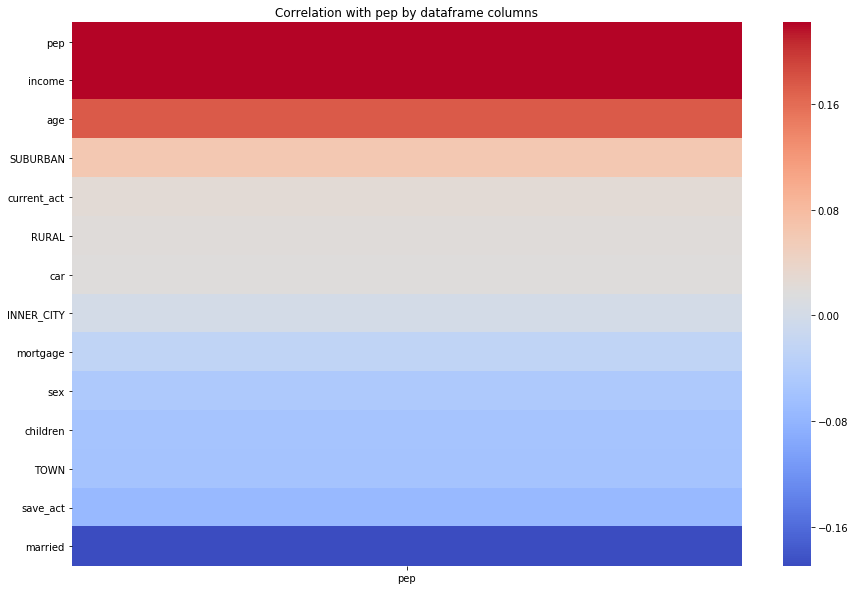

In [6]:
def corr_heatmap_by_class(df,class_to_corr,dims = (15, 10),annotate=False):
    corr=df.corr()
    fig, ax = plt.subplots(figsize=dims)

    ordered=corr[[class_to_corr]].sort_values(by=[class_to_corr],ascending=False)
    vmax=float(ordered.iloc[[1]].values)
    ax.set_title('Correlation with ' + str(class_to_corr) + ' by dataframe columns')

    return(sns.heatmap(ordered,cmap='coolwarm',vmax=vmax,annot=annotate,ax=ax))

corr_heatmap_by_class(bank,class_to_corr='pep')

# Decision Tree


In [7]:
features=list(bank.columns)
features.remove('pep')

X=bank[features]
Y=bank['pep']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state=1)

In [8]:
#test number of max leafs between 3 and 20
max_leafs=20

for leaf in range(3,max_leafs):
    
    print ('Trying max leafs equal to ' + str(leaf) + '\n')

    # Use information gain (default) 
    model_gini = DecisionTreeClassifier(max_leaf_nodes = leaf)
    model_gini.fit(X_train, y_train)
    y_gini_pred = model_gini.predict(X_test)

    y_train_gini_pred = model_gini.predict(X_train)
    
    res = pd.DataFrame(columns = ["criteria", "data", "F1_score"])
    res.loc[1, :] = ["gini", "train", f1_score(y_train, y_train_gini_pred,pos_label=True)]
    res.loc[2, :] = ["gini", "test", f1_score(y_test, y_gini_pred,pos_label=True)]
    
    print(res)
    
    print ('\n')

Trying max leafs equal to 3

  criteria   data  F1_score
1     gini  train  0.671924
2     gini   test  0.571429


Trying max leafs equal to 4

  criteria   data  F1_score
1     gini  train  0.620192
2     gini   test  0.648649


Trying max leafs equal to 5

  criteria   data  F1_score
1     gini  train  0.636132
2     gini   test  0.666667


Trying max leafs equal to 6

  criteria   data  F1_score
1     gini  train   0.75162
2     gini   test  0.714286


Trying max leafs equal to 7

  criteria   data  F1_score
1     gini  train  0.793774
2     gini   test  0.727273


Trying max leafs equal to 8

  criteria   data  F1_score
1     gini  train  0.795876
2     gini   test      0.75


Trying max leafs equal to 9

  criteria   data  F1_score
1     gini  train  0.822581
2     gini   test  0.780488


Trying max leafs equal to 10

  criteria   data  F1_score
1     gini  train  0.840336
2     gini   test       0.8


Trying max leafs equal to 11

  criteria   data  F1_score
1     gini  train  0.

In [9]:
model_gini = DecisionTreeClassifier(max_leaf_nodes = 15)
model_gini.fit(X_train, y_train)
y_gini_pred = model_gini.predict(X_test)

y_train_gini_pred = model_gini.predict(X_train)

(0, 1)

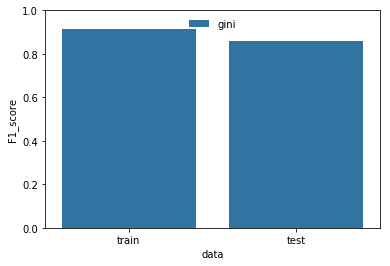

In [10]:
bp = sns.barplot(x =  "data", hue = "criteria", y = "F1_score", data = res)
bp.legend(frameon = False, loc = "upper center", ncol = 2)
bp.set_ylim(0, 1)

In [11]:
print('Gini')
print(classification_report(y_test, y_gini_pred))

Gini
             precision    recall  f1-score   support

      False       0.90      0.95      0.92        38
       True       0.90      0.82      0.86        22

avg / total       0.90      0.90      0.90        60



In [12]:
# #create a visualization of the tree -- must install graphviz and pydot2 packages for this to work
# from sklearn import tree
# dotfile = open("dtree_bank.dot", 'w')
# tree.export_graphviz(model_gini, out_file = dotfile, feature_names = features)
# dotfile.close()

# #Convert the dot file to a png

# os.system("dot -Tpng dtree_bank.dot -o dtree_bank.png")

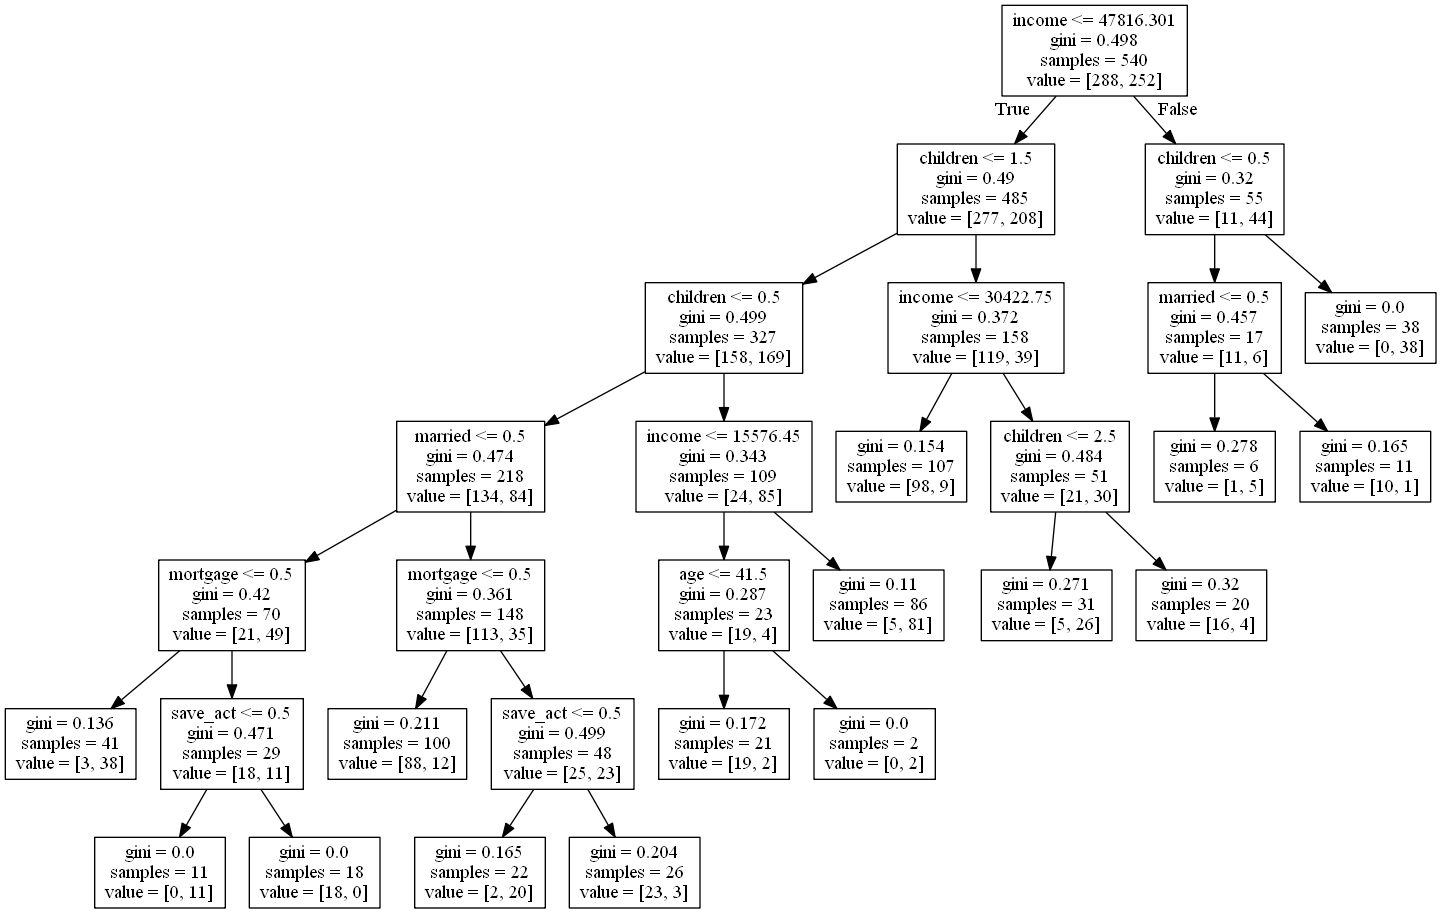

In [21]:
# show the png
bank_png=r'https://raw.githubusercontent.com/Rylan-L/data_science/master/machine_learning/dtree_bank.png'
display(Image(bank_png))


# Random Forest

In [14]:
nTrees = 120
max_depth = 15
min_node_size = 5
verbose = 0

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=nTrees, max_depth=max_depth, random_state=0, verbose=verbose, min_samples_leaf=min_node_size)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
Y_test_hat = clf.predict(X_test)
Accuracy = [1 for i in range(len(Y_test_hat)) if y_test.iloc[i] == Y_test_hat[i]]
Accuracy = round(float(np.sum(Accuracy))/len(Y_test_hat)*100,2)
print("Accuracy on Testing Data = %.2f%%"%Accuracy)

print ('F1 score for random forest ' + str(f1_score(y_test, Y_test_hat,pos_label=True)))

Accuracy on Testing Data = 86.67%
F1 score for random forest 0.7999999999999999


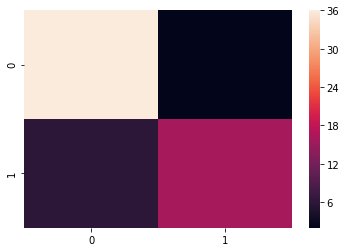

In [16]:
from sklearn.metrics import confusion_matrix

confuse=pd.DataFrame(confusion_matrix(y_test, Y_test_hat))
#plot the confusion matrix
sns.heatmap(confuse)

# # Try gradient boosted decision tree

In [17]:
nTrees = 120
max_depth = 15
min_node_size = 5
verbose = 0
learning_rate = 0.01

from sklearn.ensemble import GradientBoostingClassifier
gbm_clf = GradientBoostingClassifier(n_estimators=nTrees, loss='deviance', learning_rate=learning_rate, max_depth=max_depth, \
                                    min_samples_leaf=min_node_size)
gbm_clf.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=120,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [18]:
Y_test_gbm = gbm_clf.predict(X_test)
Accuracy_gbm = [1 for i in range(len(Y_test_gbm)) if y_test.iloc[i] == Y_test_gbm[i]]
Accuracy_gbm = round(float(np.sum(Accuracy_gbm))/len(Y_test_gbm)*100,2)
print("Accuracy on Testing Data for GBM random forest = %.2f%%"%Accuracy_gbm)

print ('F1 score for gradient boosted random forest ' + str(f1_score(y_test, Y_test_gbm,pos_label=True)))

Accuracy on Testing Data for GBM random forest = 88.33%
F1 score for gradient boosted random forest 0.8372093023255814


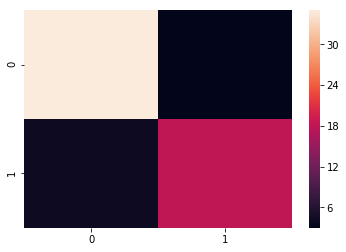

In [19]:
confuse=pd.DataFrame(confusion_matrix(y_test, Y_test_gbm))
#plot the confusion matrix
sns.heatmap(confuse)